In [1082]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import umap
from keras.optimizers import Adam
from keras.regularizers import l1

In [1083]:
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 

In [1084]:
#drop the columns that are not frequency counts
X = X.drop(X.columns[54:57], axis=1)

In [1085]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#transform to one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [1086]:
original_dim = X_train.shape[1]
latent_dim = 32
intermediate_dim = 1024

In [1087]:
#input layer
inputs = Input(shape=(original_dim,))
labels = Input(shape=(2,))

#dense layer with relu activation
h = Dense(intermediate_dim, activation='relu')(inputs)

In [1088]:
## encoder model ##

# parameters of latent distribution
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [1089]:
# sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [1090]:
# sample vector from latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [1091]:
# classifier
classifier_h = Dense(intermediate_dim, activation='relu')(z)
classifier_output = Dense(2, activation='softmax')(classifier_h)

In [1092]:
### Decoder model ###

# Dense layer with relu activation takes sampled latent space vector z and maps it to an intermediate space
decoder_h = Dense(intermediate_dim, activation='relu')

# Dense layer with sigmoid activation takes the intermediate space vector and maps it back to the original dimension
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [1093]:
# VAE model
vae = Model([labels, inputs], [x_decoded_mean,classifier_output])

In [1094]:
# Define the VAE loss

# Reconstruction loss
#rec_loss = original_dim * binary_crossentropy(inputs, x_decoded_mean)
rec_loss = K.mean(K.square(inputs - x_decoded_mean), axis=-1)
# KL divergence loss 
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#classifier loss
class_loss = binary_crossentropy(labels, classifier_output)
# Total loss
vae_loss = K.mean(rec_loss + 0.1*kl_loss + class_loss)



In [1095]:
vae.add_loss(vae_loss)
optimizer = Adam(learning_rate=0.000001)
vae.compile(optimizer=optimizer)

In [1096]:
# Train the VAE model
vae.fit([y_train, X_train], epochs=250, batch_size=64, validation_data=([y_test, X_test], None))

Epoch 1/250
58/58 [==============================] - 3s 12ms/step - loss: 1.7031 - val_loss: 1.7397
Epoch 2/250
58/58 [==============================] - 0s 8ms/step - loss: 1.6967 - val_loss: 1.7281
Epoch 3/250
58/58 [==============================] - 0s 8ms/step - loss: 1.6921 - val_loss: 1.7194
Epoch 4/250
58/58 [==============================] - 0s 7ms/step - loss: 1.6753 - val_loss: 1.7170
Epoch 5/250
58/58 [==============================] - 0s 8ms/step - loss: 1.6744 - val_loss: 1.7083
Epoch 6/250
58/58 [==============================] - 0s 7ms/step - loss: 1.6766 - val_loss: 1.6999
Epoch 7/250
58/58 [==============================] - 0s 7ms/step - loss: 1.6619 - val_loss: 1.6931
Epoch 8/250
58/58 [==============================] - 0s 8ms/step - loss: 1.6510 - val_loss: 1.6863
Epoch 9/250
58/58 [==============================] - 0s 7ms/step - loss: 1.6499 - val_loss: 1.6837
Epoch 10/250
58/58 [==============================] - 0s 7ms/step - loss: 1.6377 - val_loss: 1.6787
Epoch 11

In [1097]:
# Build the encoder model 
encoder = Model(inputs, [z_mean, z_log_var])
z_mean, z_log_var = encoder.predict(X_test, batch_size=64)

15/15 [==============================] - 0s 10ms/step


In [1098]:
# locate data points in latent space
data_point = X_test.loc[0]
data_point_encoding = [z_mean[0], z_log_var[0]]

In [1099]:
# draw 5 samples from the latent distribution
epsilon = np.random.normal(size=(5, latent_dim))
z_sample = data_point_encoding[0] + np.exp(data_point_encoding[1] / 2) * epsilon


In [1100]:
# build decoder model
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)


In [1101]:
# decode samples
x_decoded = decoder.predict(z_sample)

1/1 [==============================] - 0s 224ms/step


In [1102]:
# build classifier model
classifier = Model(inputs, classifier_output)
classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# evaluate classifier
score = classifier.evaluate(X_test, y_test, batch_size=64)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

15/15 [==============================] - 1s 3ms/step - loss: 0.5958 - accuracy: 0.6949
Test loss: 0.595767617225647
Test accuracy: 0.6948968768119812


In [1103]:
# visualize decoded samples and original data point
print("Original data point:")
print(np.array(data_point))
print("Decoded sample:")
print(x_decoded[0])

Original data point:
[0.    0.64  0.64  0.    0.32  0.    0.    0.    0.    0.    0.    0.64
 0.    0.    0.    0.32  0.    1.29  1.93  0.    0.96  0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.778 0.    0.   ]
Decoded sample:
[0.15066014 0.2437226  0.22798693 0.17689742 0.3942986  0.1419033
 0.20916314 0.1490447  0.16096552 0.24113302 0.11922631 0.58299255
 0.19337271 0.16612913 0.17572364 0.2214134  0.15402065 0.2523667
 0.8432965  0.13301079 0.6468854  0.22517698 0.21744058 0.15591104
 0.52856153 0.3050831  0.59417194 0.15008481 0.21667784 0.17897615
 0.1050822  0.1651482  0.12160098 0.14515276 0.16667657 0.25136432
 0.13530667 0.11049824 0.16089867 0.1367122  0.15153359 0.19373217
 0.1589692  0.23604712 0.32940337 0.23658988 0.11174035 0.2163184
 0.17834494 0.17703384 0.14561191 0.31111887 0.1383045  0.3024347 ]


In [1104]:
visualization_data = np.vstack(list(np.array(X_test)[1:])+ [data_point] + list(x_decoded))

In [1105]:
# Create labels for the visualization
labels = ["other data point in X_test"]*len(X_test[1:]) + ["Original data point"] + ["Generated"]*5
colors = ["darkslategray"]*len(X_test[1:]) + ["red"] + ["sienna"]*5

In [1106]:
# Apply UMAP for visualization
umap_model = umap.UMAP(n_components=2)
visualized_data = umap_model.fit_transform(visualization_data)

/Users/hannah/anaconda3/envs/research_seminar/lib/python3.10/site-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


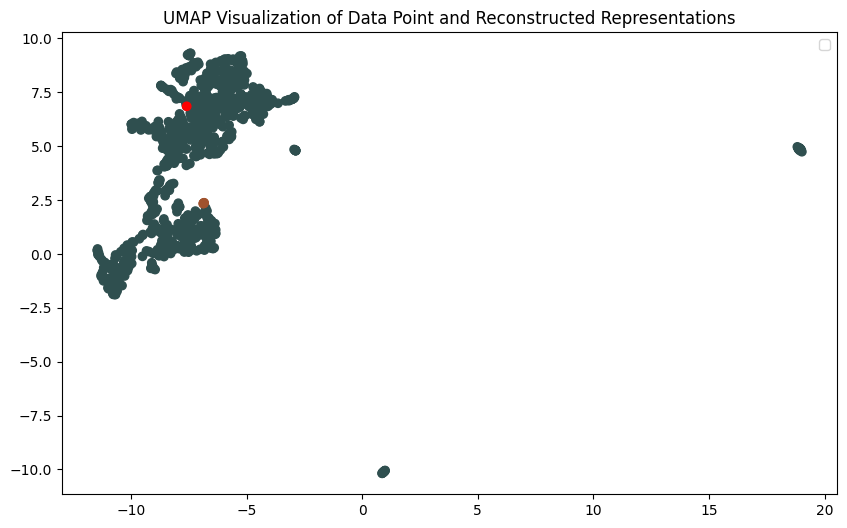

In [1107]:
# Plot the visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(visualized_data[:, 0], visualized_data[:, 1], c=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.title('UMAP Visualization of Data Point and Reconstructed Representations')
plt.show()